In [1]:
from IPython.display import display, HTML

html = """
<div style="background:linear-gradient(135deg,#1a1a2e,#16213e,#0f3460);border-radius:16px;padding:40px;text-align:center;font-family:'Segoe UI',Arial,sans-serif;box-shadow:0 8px 32px rgba(0,0,0,0.4);">
  <div style="font-size:2.5em;">🔍</div>
  <h1 style="color:#e0e0e0;font-size:2em;margin:8px 0;">Analisis Exploratorio de Datos</h1>
  <p style="color:#a0aec0;letter-spacing:2px;text-transform:uppercase;font-size:0.95em;">EDA · Distribucion de Clases · Analisis de Sentimiento</p>
  <div style="background:rgba(255,255,255,0.06);border:1px solid rgba(255,255,255,0.1);border-radius:10px;padding:16px 24px;max-width:650px;margin:24px auto 0;text-align:left;color:#cbd5e0;font-size:0.93em;line-height:1.7;">
    Exploramos la estructura del dataset de textos legales: distribucion de clases,
    valores nulos, longitud de documentos y analisis de sentimiento por categoria.
  </div>
</div>
"""
display(HTML(html))


## 1. Carga del Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/legal_text_classification.csv")
print(f"Filas: {df.shape[0]:,}  |  Columnas: {df.shape[1]}")
df.head()


Filas: 24,985  |  Columnas: 4


,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


## 2. Estructura y Valores Nulos

In [3]:
df.info()
print("\nValores nulos por columna:")
print(df.isnull().sum())


<class 'pandas.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   case_id       24985 non-null  str  
 1   case_outcome  24985 non-null  str  
 2   case_title    24985 non-null  str  
 3   case_text     24809 non-null  str  
dtypes: str(4)
memory usage: 780.9 KB

Valores nulos por columna:
case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64


## 3. Distribucion de Clases

Visualizamos cuantos documentos hay por cada categoria de resultado legal. El desbalance extremo sera un desafio clave para el modelado.

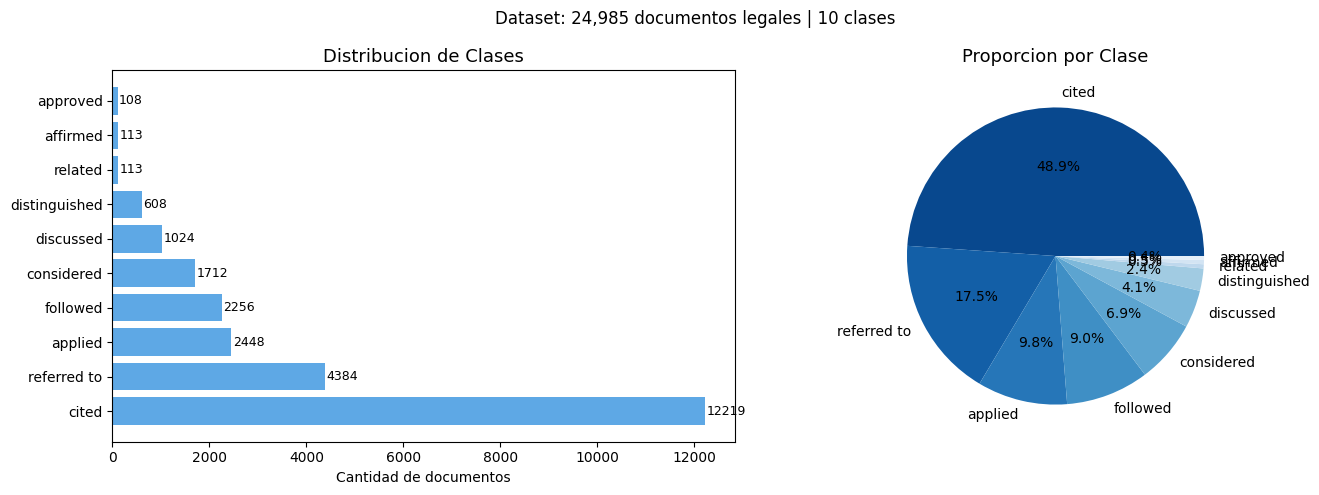


Ratio desbalance max/min: 113x
case_outcome
cited            12219
referred to       4384
applied           2448
followed          2256
considered        1712
discussed         1024
distinguished      608
related            113
affirmed           113
approved           108
Name: count, dtype: int64


In [4]:
dist = df["case_outcome"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barras
axes[0].barh(dist.index, dist.values, color="#4299e1", alpha=0.85)
axes[0].set_title("Distribucion de Clases", fontsize=13)
axes[0].set_xlabel("Cantidad de documentos")
for i, v in enumerate(dist.values):
    axes[0].text(v + 30, i, str(v), va="center", fontsize=9)

# Pie
axes[1].pie(dist.values, labels=dist.index, autopct="%1.1f%%",
            colors=sns.color_palette("Blues_r", len(dist)))
axes[1].set_title("Proporcion por Clase", fontsize=13)

plt.suptitle(f"Dataset: {len(df):,} documentos legales | {df['case_outcome'].nunique()} clases", fontsize=12)
plt.tight_layout()
plt.savefig("../reports/eda_distribucion.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nRatio desbalance max/min: {dist.max() // dist.min()}x")
print(dist)


## 4. Longitud de Documentos

Analizamos cuantas palabras tienen los textos legales por categoria.

Estadisticas de longitud de documentos:
count    24809.0
mean       454.9
std       1143.2
min         17.0
25%        147.0
50%        244.0
75%        436.0
max      22466.0
Name: longitud, dtype: float64


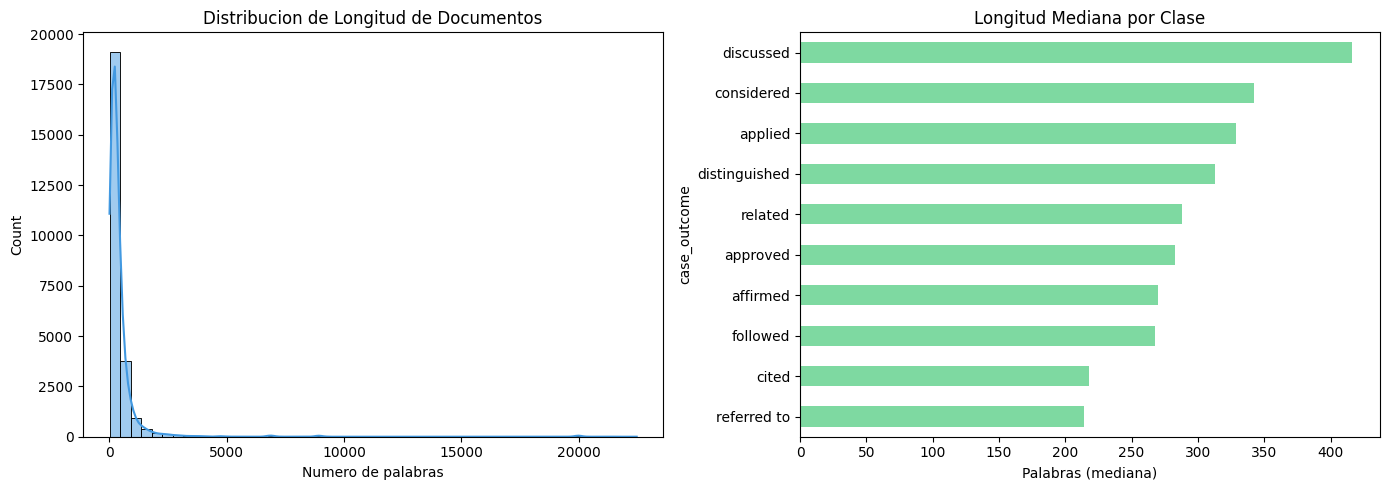

In [5]:
df_valid = df.dropna(subset=["case_text"]).copy()
df_valid["longitud"] = df_valid["case_text"].astype(str).apply(lambda x: len(x.split()))

print("Estadisticas de longitud de documentos:")
print(df_valid["longitud"].describe().round(1))

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_valid["longitud"], bins=50, kde=True, ax=axes[0], color="#4299e1")
axes[0].set_title("Distribucion de Longitud de Documentos")
axes[0].set_xlabel("Numero de palabras")

df_valid.groupby("case_outcome")["longitud"].median().sort_values().plot(
    kind="barh", ax=axes[1], color="#68d391", alpha=0.85
)
axes[1].set_title("Longitud Mediana por Clase")
axes[1].set_xlabel("Palabras (mediana)")

plt.tight_layout()
plt.savefig("../reports/eda_longitud.png", dpi=150, bbox_inches="tight")
plt.show()


## 5. Analisis de Sentimiento con TextBlob

Medimos polaridad (-1=negativo, +1=positivo) y subjetividad (0=objetivo, 1=subjetivo) de cada documento.

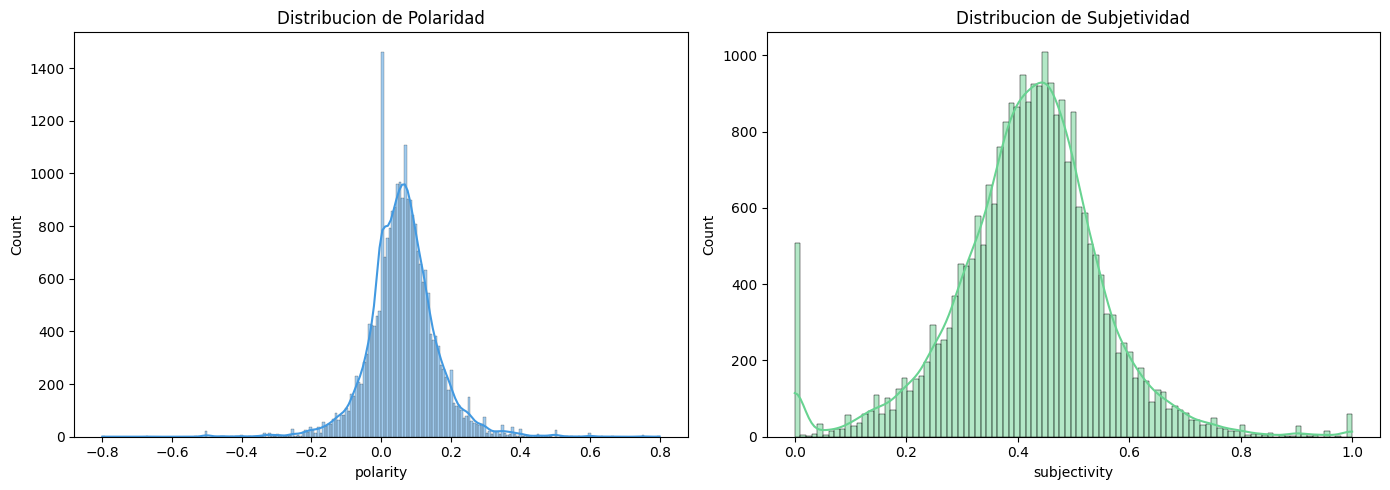

Promedio por categoria:
               polarity  subjectivity
case_outcome                         
affirmed         0.0263        0.3585
applied          0.0616        0.4318
approved         0.0744        0.4083
cited            0.0619        0.4150
considered       0.0694        0.4275
discussed        0.0714        0.4296
distinguished    0.0663        0.4214
followed         0.0651        0.4321
referred to      0.0583        0.4074
related          0.0535        0.3775


In [6]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text): return 0.0, 0.0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df["polarity"], df["subjectivity"] = zip(*df["case_text"].apply(get_sentiment))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["polarity"],     kde=True, ax=axes[0], color="#4299e1")
sns.histplot(df["subjectivity"], kde=True, ax=axes[1], color="#68d391")
axes[0].set_title("Distribucion de Polaridad")
axes[1].set_title("Distribucion de Subjetividad")
plt.tight_layout()
plt.savefig("../reports/eda_sentimiento.png", dpi=150, bbox_inches="tight")
plt.show()

print("Promedio por categoria:")
print(df.groupby("case_outcome")[["polarity","subjectivity"]].mean().round(4))


## 6. Sentimiento Interactivo por Clase

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

clases_disponibles = sorted(df["case_outcome"].unique().tolist())

def plot_sentimiento(clase, metrica):
    col = "polarity" if metrica == "Polaridad" else "subjectivity"
    xlabel = "Polaridad (-1 a +1)" if metrica == "Polaridad" else "Subjetividad (0 a 1)"

    df_clase = df[df["case_outcome"] == clase]
    df_resto = df[df["case_outcome"] != clase]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{metrica}: {clase} vs Resto", fontsize=13, fontweight="bold")

    sns.histplot(df_resto[col], ax=axes[0], color="#718096", alpha=0.6, kde=True, label="Resto")
    sns.histplot(df_clase[col], ax=axes[0], color="#4299e1", alpha=0.7, kde=True, label=clase)
    axes[0].set_title(f"Distribucion de {metrica}")
    axes[0].set_xlabel(xlabel)
    axes[0].legend()

    top_clases = df["case_outcome"].value_counts().head(8).index.tolist()
    df_top = df[df["case_outcome"].isin(top_clases)]
    orden = df_top.groupby("case_outcome")[col].median().sort_values().index
    colores = ["#4299e1" if c == clase else "#718096" for c in orden]
    sns.boxplot(data=df_top, x=col, y="case_outcome", order=orden, palette=colores, ax=axes[1])
    axes[1].set_title(f"{metrica} por categoria")
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("")

    media_clase = df_clase[col].mean()
    media_global = df[col].mean()
    dif = media_clase - media_global
    print(f"  Media {clase}: {media_clase:.4f}  |  Media global: {media_global:.4f}  |  Diferencia: {dif:+.4f}")
    plt.tight_layout()
    plt.show()

interact(plot_sentimiento,
    clase=widgets.Dropdown(options=clases_disponibles, value="cited", description="Clase:"),
    metrica=widgets.Dropdown(options=["Polaridad", "Subjetividad"], description="Metrica:")
);
